In [229]:
# Importation 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import os
import openpyxl
from tsfresh import extract_features, select_features
import matplotlib.pyplot as plt

directory = os.getcwd()

In [230]:
# Importation données NDVI
donnees = pd.read_csv(f"{directory}/donnees/resultats-2.csv", sep = ";", parse_dates = ["date"], dayfirst = True)

# Typage des colonnes
donnees['parcelle'] = donnees['parcelle'].astype('string')
donnees["parcelle"] = donnees["parcelle"].map(lambda x:x.replace('_','').lower())
donnees.columns = donnees.columns.str.replace('NDVI_moy', 'ndvi')
donnees = donnees.set_index('date', drop = False)

donnees["campagne"] = donnees["date"].dt.year # on utilise cette colonne campagne pour les jointures pr récup le peuplement et le précédent
donnees['campagne'] = donnees['campagne'].astype('string')


In [231]:
peuplement_1 = pd.read_excel(f"{directory}/donnees/peuplement/donnees2022_BA-2.xlsx", engine='openpyxl', parse_dates = ["date"])
peuplement_1 = peuplement_1.loc[:,["parcelle","date","peuplement"]]

peuplement_2 = pd.read_excel(f"{directory}/donnees/peuplement/Placette_TRN22_beauce.xlsx", engine='openpyxl', parse_dates = ["date_obs"])
peuplement_2 = peuplement_2.loc[:,["numero_parcelle","date_obs","peuplement"]]
peuplement_2.columns = peuplement_2.columns.str.replace('numero_parcelle', 'parcelle')
peuplement_2.columns = peuplement_2.columns.str.replace('date_obs','date')
peuplement_2 = peuplement_2[peuplement_2["parcelle"] != "80_22"] # la dernière ligne a un NA dans col peuplement

peuplement = peuplement_1.merge(peuplement_2)
peuplement = pd.concat([peuplement_1, peuplement_2], axis = 0, ignore_index = True)
peuplement["parcelle"] = peuplement["parcelle"].map(lambda x:x.replace('_','').lower())
peuplement['parcelle'] = peuplement['parcelle'].astype('string')
peuplement = peuplement.groupby(["parcelle"]).agg({"date":["first"], "peuplement":["mean"]})
peuplement.columns = peuplement.columns.droplevel()
peuplement.columns = ["date","peuplement"]
peuplement = peuplement.reset_index()

# Intégration aux données NDVI
peuplement["campagne"] = peuplement["date"].dt.year.map(lambda x:int(x))
peuplement['campagne'] = peuplement['campagne'].astype('string')
peuplement = peuplement.drop(["date"], axis = 1)

donnees = donnees.merge(peuplement,on=['campagne','parcelle'],how='left')

donnees['parcelle'] = donnees['parcelle'].astype('string')

In [232]:
donnees = donnees.sort_values(["parcelle","date"])
donnees = donnees.dropna(axis = 0, subset=['peuplement'])

df = donnees.loc[:,["parcelle","date","ndvi"]]
y = donnees.loc[:,["parcelle","peuplement","campagne"]].drop_duplicates().peuplement

y = y.reset_index(drop = True)
df = df.reset_index(drop = True)

In [233]:
print(df)

       parcelle       date  ndvi
0          1722 2022-05-10  3606
1          1722 2022-05-30  7392
2          1722 2022-06-14  7679
3          1722 2022-06-19  7855
4          1722 2022-07-14  4981
..          ...        ...   ...
607  tivillers8 2022-08-17  2002
608  tivillers8 2022-08-20  2106
609  tivillers8 2022-08-22  1807
610  tivillers8 2022-08-25  1835
611  tivillers8 2022-08-30  2051

[612 rows x 3 columns]


In [234]:
# Ecriture des données dans un excel pour pouvoir passer facilement la date dans un format numéro de jour de l'année
df.to_excel('df.xlsx')

In [235]:
# Lecture de csv résultant 
df_doy = pd.read_csv(f"{directory}/df.csv", sep = ";")
print(df_doy)

       parcelle  date  ndvi
0          1722   129  3606
1          1722   149  7392
2          1722   164  7679
3          1722   169  7855
4          1722   194  4981
..          ...   ...   ...
607  tivillers8   228  2002
608  tivillers8   231  2106
609  tivillers8   233  1807
610  tivillers8   236  1835
611  tivillers8   241  2051

[612 rows x 3 columns]


In [236]:
# Stockage des données ndvi et leur index en jour de l'année associé dans une liste de liste 
parcelle_nb = df["parcelle"].drop_duplicates().values.tolist()
groups = df_doy.groupby(['parcelle'])
doy_ndvi = []
for name in parcelle_nb : 
    doy_ndvi.append([groups.get_group(name)['date'].values.tolist(),groups.get_group(name)['ndvi'].values.tolist()])
print(doy_ndvi[:10])

[[[129, 149, 164, 169, 194, 204, 214, 219, 224], [3606, 7392, 7679, 7855, 4981, 6421, 4475, 3795, 3458]], [[129, 149, 164, 169, 194, 204, 214, 219, 224], [2808, 7321, 6390, 7689, 4915, 4632, 3579, 3426, 3103]], [[99, 129, 149, 164, 169, 194, 204, 214, 219, 224], [1633, 2381, 7082, 6419, 7486, 4967, 4808, 3219, 2991, 2685]], [[99, 129, 149, 164, 169, 194, 204, 214, 219, 224], [1479, 1673, 7711, 7945, 8177, 6858, 7747, 4773, 3448, 3650]], [[99, 129, 149, 164, 169, 194, 204, 214, 219, 224, 239], [2231, 3310, 5527, 7316, 7164, 6658, 7114, 5303, 3939, 3058, 2344]], [[99, 129, 149, 164, 169, 194, 204, 214, 219, 224], [2235, 4586, 7896, 7891, 7848, 5548, 7146, 5333, 4716, 4389]], [[99, 129, 149, 164, 169, 194, 204, 214, 219, 224], [8680, 5639, 8423, 7026, 5228, 2112, 1837, 1461, 1578, 1523]], [[99, 129, 149, 164, 169, 194, 204, 214, 219, 224], [2248, 4204, 6281, 7485, 7354, 5894, 6770, 4782, 3872, 3347]], [[99, 129, 149, 164, 169, 194, 204, 214, 219, 224], [7685, 6232, 7676, 6747, 5432, 2857,

In [57]:
#Pour que tous les index commencent à 0
doy0_ndvi = []
for parc in doy_ndvi : 
    new_doy = []
    for day in parc[0]:
        new_doy.append(day-parc[0][0])
    doy0_ndvi.append([new_doy,parc[1]])
print(doy0_ndvi[:10])



[[[0, 20, 35, 40, 65, 75, 85, 90, 95], [3606, 7392, 7679, 7855, 4981, 6421, 4475, 3795, 3458]], [[0, 20, 35, 40, 65, 75, 85, 90, 95], [2808, 7321, 6390, 7689, 4915, 4632, 3579, 3426, 3103]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125], [1633, 2381, 7082, 6419, 7486, 4967, 4808, 3219, 2991, 2685]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125], [1479, 1673, 7711, 7945, 8177, 6858, 7747, 4773, 3448, 3650]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125, 140], [2231, 3310, 5527, 7316, 7164, 6658, 7114, 5303, 3939, 3058, 2344]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125], [2235, 4586, 7896, 7891, 7848, 5548, 7146, 5333, 4716, 4389]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125], [8680, 5639, 8423, 7026, 5228, 2112, 1837, 1461, 1578, 1523]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125], [2248, 4204, 6281, 7485, 7354, 5894, 6770, 4782, 3872, 3347]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125], [7685, 6232, 7676, 6747, 5432, 2857, 2129, 2832, 3387, 3122]], [[0, 20, 35, 38, 40, 53, 63, 65, 68

In [237]:
# On ajoute les valeurs manquante avec des NA
doy_NA = []
for parc in doy_ndvi : 
    indice = []
    val = []
    ind2 = 0
    for i in range(int((parc[0][-1]-parc[0][0])/5)) : 
        if i*5 + parc[0][0] in parc[0]:
            indice.append(i*5+ parc[0][0])
            val.append(parc[1][ind2])
            ind2 += 1
        else : 
            indice.append(i*5+ parc[0][0])
            val.append(np.nan)
    doy_NA.append([indice,val])
print(doy_NA[:10])


    

[[[129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219], [3606, nan, nan, nan, 7392, nan, nan, 7679, 7855, nan, nan, nan, nan, 4981, nan, 6421, nan, 4475, 3795]], [[129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219], [2808, nan, nan, nan, 7321, nan, nan, 6390, 7689, nan, nan, nan, nan, 4915, nan, 4632, nan, 3579, 3426]], [[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219], [1633, nan, nan, nan, nan, nan, 2381, nan, nan, nan, 7082, nan, nan, 6419, 7486, nan, nan, nan, nan, 4967, nan, 4808, nan, 3219, 2991]], [[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219], [1479, nan, nan, nan, nan, nan, 1673, nan, nan, nan, 7711, nan, nan, 7945, 8177, nan, nan, nan, nan, 6858, nan, 7747, nan, 4773, 3448]], [[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 15

In [238]:
#On repasse tout ça en dataframe que l'on stocke dans une liste pour pouvoir utiliser l'interpolation
datalist = []
for parc in doy_NA : 
    datalist.append(pd.DataFrame(index=parc[0]))
    datalist[-1]["ndvi"] = parc[1]
print(datalist[0])

       ndvi
129  3606.0
134     NaN
139     NaN
144     NaN
149  7392.0
154     NaN
159     NaN
164  7679.0
169  7855.0
174     NaN
179     NaN
184     NaN
189     NaN
194  4981.0
199     NaN
204  6421.0
209     NaN
214  4475.0
219  3795.0


In [239]:
# On remplace les donnees manquantes par interpolation linaires 
df_interpolate = [ k.interpolate() for k in datalist]
print(df_interpolate[0])

            ndvi
129  3606.000000
134  4552.500000
139  5499.000000
144  6445.500000
149  7392.000000
154  7487.666667
159  7583.333333
164  7679.000000
169  7855.000000
174  7280.200000
179  6705.400000
184  6130.600000
189  5555.800000
194  4981.000000
199  5701.000000
204  6421.000000
209  5448.000000
214  4475.000000
219  3795.000000


In [19]:
#On repasse en liste de liste 
ndvi = [k['ndvi'].values.tolist() for k in df_interpolate]

#### Utilisation d'un SVR avec le package tslearn

On va utiliser le package tslearn pour faire une regression avec des séries temporelles de tailles différentes.

In [73]:
#Création des données d'entrainement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ndvi, y, test_size=0.3, random_state=0)

In [240]:
#Utilisation du package tslearn pour faire une regression avec des séries temporelles de tailles différentes 
from tslearn.svm import TimeSeriesSVR
from tslearn.utils import to_time_series_dataset
from sklearn.model_selection import GridSearchCV

X_train_ts = to_time_series_dataset(X_train)
X_test_ts = to_time_series_dataset(X_test)
clf = TimeSeriesSVR(kernel='gak',C = 1)
clf.fit(X_train_ts,y_train)
print(clf.score(X_test_ts,y_test))

-0.6165084348812386


In [241]:
print(clf.predict(X_test_ts))
print(y_test)

[55999.05485741 55999.56642899 55996.31659686 55998.49002173
 55997.52770211 55998.20934365 55996.33304582 55997.3735974
 55999.46650232 55997.19540788 55996.73469933 55997.17616714
 56000.03918664]
25    60555.555555
35    38000.000000
29    38181.818182
4     43600.000000
10    56000.000000
31    43666.666666
27    49333.333334
11    58800.000000
36    41200.000000
30    45454.545456
28    29090.909090
20    30000.000000
38    72000.000000
Name: peuplement, dtype: float64


On remarque qu'avec le C par défault, le SVR prédit globalement la même valeur pour tous les peuplements.
On peut donc essayer de jouer sur le C. 

In [144]:
#Effets de C 
abscisse = [1,5,10,50,100,200,300,500,700,1000,2000,5000,10000,15000,20000,30000,50000]
test = []
train = []
for C in abscisse :
    clf = TimeSeriesSVR(kernel='gak',C = C)
    clf.fit(X_train_ts,y_train)
    test.append(clf.score(X_test_ts,y_test))
    train.append(clf.score(X_train_ts,y_train))


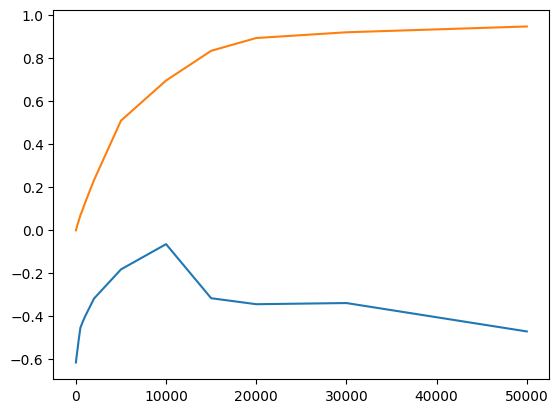

In [145]:
plt.plot(abscisse,test)
plt.plot(abscisse,train)

On remarque que lorsque l'on augmente fortement le C, on observe du sur-apprentissage. En revanche, même avec un C optimal, on n'obtient pas de performances correctes.

On peut essayer de faire varier C et epsilon ensemble avec un grid search.

In [129]:
#Grid search, mais bon on reste sur des performances catastrophiques
clf = TimeSeriesSVR(kernel='gak')
param_grid_svm = {'epsilon': [0.01,0.1,1,5,8,10,15,20],'C':[10000,20000,50000]}
grid_svr = GridSearchCV(clf, param_grid = param_grid_svm, n_jobs=3) #seul kernel gérant les séquences de tailles différentes
grid_svr.fit(X_train_ts,y_train)
print("SVR - paramètre epsilon optimal :", grid_svr.best_params_)
print("SVR - Perf en apprentissage (avec avec epsilon optimal) : ",grid_svr.best_estimator_.score(X_train_ts,y_train))
print("SVR - Perf en test (avec epsilon optimal) : ",grid_svr.best_estimator_.score(X_test_ts,y_test))

SVR - paramètre epsilon optimal : {'C': 50000, 'epsilon': 15}
SVR - Perf en apprentissage (avec avec epsilon optimal) :  0.9447786249286811
SVR - Perf en test (avec epsilon optimal) :  -0.46451492267458416


Les perfomances restent très mauvaises. 

#### Implémentation des K plus proche voisins avec du DTW


Principe de DTW : calculer des distances entre des séries potentiellement décalée temporellement et de tailles différentes. 

<AxesSubplot: xlabel='Index', ylabel='Query value'>

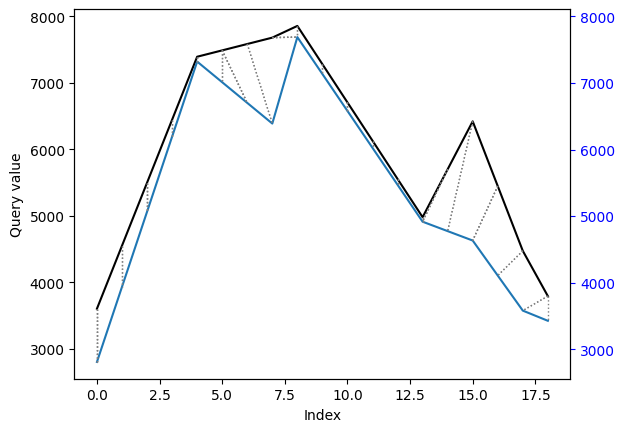

In [243]:
import dtw as dtw
allign  = dtw.dtw(ndvi[20],ndvi[22],keep_internals=True).distance
dtw.dtw(ndvi[0],ndvi[1], keep_internals=True, step_pattern=dtw.rabinerJuangStepPattern(6, "c")).plot(type="twoway",offset=-2)

In [244]:
# Fonction pour faire la prédiction à partir de l'ensemble d'apprentissage
def get_neighbors(x_train,y_train,test_row, num_neighbors):
    distances = list()
    for train_row,y_row in zip(x_train,y_train):
        dist = dtw.dtw(test_row,train_row,keep_internals=True).distance
        distances.append((y_row, dist))
        distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return sum(neighbors)/num_neighbors


In [255]:
#Calcul de la performance pour plusieurs valeur du nombre de voisins séléctionnés
from sklearn.metrics import r2_score
k_y_predict = [ [get_neighbors(X_train,y_train,test_row, k) for test_row in X_test] for k in range(1,28)]
k_y_train_predict = [ [get_neighbors(X_train,y_train,test_row, k) for test_row in X_train] for k in range(1,28)]
score = [r2_score(y_test,y_pred) for y_pred in k_y_predict]
score_train = [r2_score(y_train,y_pred) for y_pred in k_y_train_predict]
abscisse = [k for k in range(1,28)]

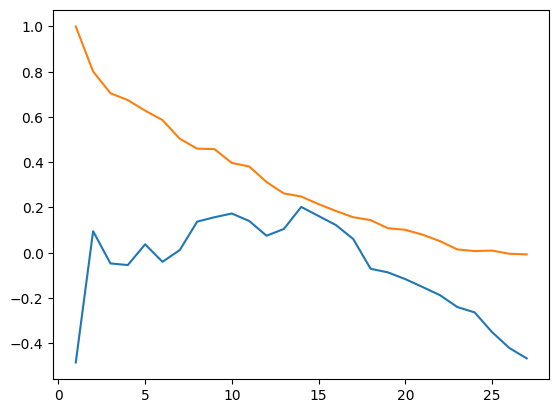

In [256]:
import matplotlib.pyplot as plt
plt.plot(abscisse,score)
plt.plot(abscisse,score_train)

On voit donc que l'on peut arriver à un R2 proche 0,2. 

#### Travailler des séries de même taille 

Deux solutions : 
- la fonction TimeSeriesResampler de tslearn
- couper les données


Commencer par utiliser la fonction de tslearn

In [157]:
from tslearn.preprocessing import TimeSeriesResampler
X = to_time_series_dataset(ndvi)
resampled_X = TimeSeriesResampler(sz=X.shape[1]).fit_transform(X)


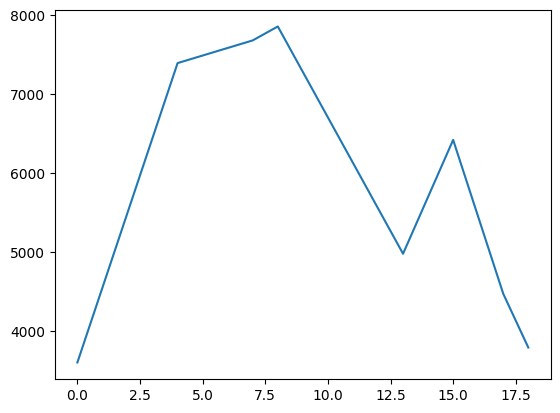

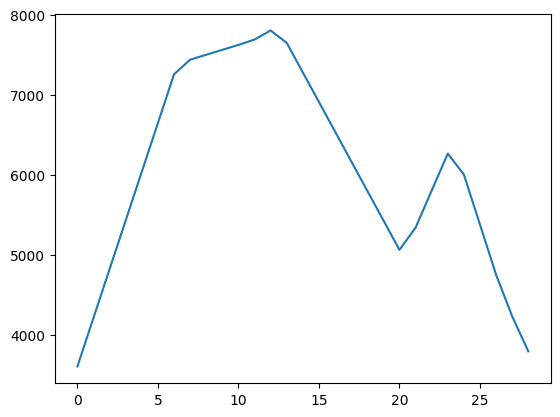

In [158]:
plt.plot(X[0])
plt.figure()
plt.plot(resampled_X[0])

On a une perte d'information temporelle car les courbes sont dilatés/contractés pour faire la bonne taille. 

On peut aussi couper les données.

In [197]:
doy_interpolate = [ [parc.index.values.tolist(),parc['ndvi'].values.tolist()] for parc in df_interpolate ]

In [198]:
debut = [ k[0][0] for k in doy_interpolate]
fin = [ k[0][-1] for k in doy_interpolate]
print(debut,fin)
print(max(debut),min(fin))

[129, 129, 99, 99, 99, 99, 99, 99, 99, 129, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 94, 94, 112, 99, 99, 99, 99, 99, 99, 99, 122, 93, 93, 93, 93, 93, 93, 93] [219, 219, 219, 219, 234, 219, 219, 219, 219, 234, 234, 219, 219, 234, 219, 219, 219, 219, 234, 234, 234, 219, 219, 234, 234, 217, 234, 234, 234, 234, 234, 234, 234, 217, 233, 233, 233, 233, 233, 233, 233]
129 217


In [209]:
day_ndvi_cut = []
for parc in doy_interpolate : 
    list_val = []
    list_day = []
    for day,val in zip(parc[0],parc[1]):
        if day >= 129 and day <= 213 : 
            list_day.append(day)
            list_val.append(val)
    day_ndvi_cut.append([list_day,list_val])


In [210]:
debut = [ k[0][0] for k in day_ndvi_cut]
fin = [ k[0][-1] for k in day_ndvi_cut]
length = [len(k[0]) for k in day_ndvi_cut]
print(debut,fin,length)

[129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 132, 129, 129, 129, 129, 129, 129, 129, 132, 133, 133, 133, 133, 133, 133, 133] [209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 212, 209, 209, 209, 209, 209, 209, 209, 212, 213, 213, 213, 213, 213, 213, 213] [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]


In [211]:
ndvi_cut = [parc[1] for parc in day_ndvi_cut]

Testons les deux possibilités 

In [270]:
nsamples, nx, ny = resampled_X.shape
resampled_X= resampled_X.reshape((nsamples,nx*ny))
Xr_train, Xr_test, yr_train, yr_test = train_test_split(resampled_X, y, test_size=0.3, random_state=0)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(ndvi_cut, y, test_size=0., random_state=0)



ValueError: not enough values to unpack (expected 3, got 2)

In [266]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor



mod_rdForest = RandomForestRegressor(max_depth=2, random_state=0)
mod_XTrees = ExtraTreesRegressor(n_estimators=100, random_state=0)
mod_AdaB = AdaBoostRegressor(random_state=0, n_estimators=100)
mod_GradB = GradientBoostingRegressor(random_state=0)
mod_SVR = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
mod_Ridg = Ridge(alpha=1.0)
mod_BayRidg = BayesianRidge()
mod_Log = LogisticRegression(random_state=0)
mod_Twd = TweedieRegressor()
mod_SGD = make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))
mod_hub = HuberRegressor()
mod_DecTree = DecisionTreeRegressor(random_state=0)
mod_bst = xgb.XGBRegressor()
mod_KNN = KNeighborsRegressor(n_neighbors=6)
mod_KNNDTW = KNeighborsRegressor(n_neighbors=6,metric=dtw)
list_mod = [mod_rdForest,mod_XTrees,mod_AdaB,mod_GradB,mod_SVR,mod_Ridg,mod_BayRidg,mod_Twd,mod_SGD,mod_hub,mod_DecTree,mod_bst,mod_KNN]







In [267]:
from tslearn.metrics import dtw
mod_score = []
for mod in list_mod : 
    print(mod)
    mod.fit(Xc_train,yc_train)
    y_pred = mod.predict(Xc_test)
    mod_score.append(r2_score(y_test,y_pred))
    

RandomForestRegressor(max_depth=2, random_state=0)
ExtraTreesRegressor(random_state=0)
AdaBoostRegressor(n_estimators=100, random_state=0)
GradientBoostingRegressor(random_state=0)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])
Ridge()
BayesianRidge()
TweedieRegressor()
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])
HuberRegressor()
DecisionTreeRegressor(random_state=0)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_dep

/Users/antoinedegenne/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Users/antoinedegenne/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antoinedegenne/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n

In [268]:
mod_score

[-0.12515633608913168,
 -0.34109931424836026,
 -0.6656370430925769,
 -0.39376554060305113,
 -0.6165568055501582,
 -5.060171172434661,
 -0.4684818284023837,
 -2.926137435341044,
 -0.6804889125431681,
 -1.1267715243061573,
 0.2083633730107095,
 0.052276095078677476,
 -0.08201730219177361]

In [214]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(Xr_train, yr_train)
print('resampled :',neigh.score(Xr_test,yr_test))
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(Xc_train, yc_train)
print('cut :',neigh.score(Xc_test,yc_test))

resampled : -1.6004252893446966
cut : 0.07280578639785207


In [222]:
abscisse = range(1,21)
r_perf = []
c_perf = []
for n in abscisse:
    neigh = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(Xr_train, yr_train)
    r_perf.append(neigh.score(Xr_test,yr_test))
    neigh = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(Xc_train, yc_train)
    c_perf.append(neigh.score(Xc_test,yc_test))

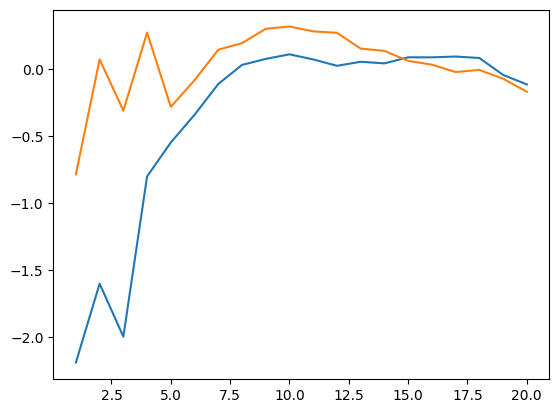

In [223]:
plt.plot(abscisse,r_perf)
plt.plot(abscisse,c_perf)

In [219]:
from sklearn.model_selection import cross_val_score
neigh = KNeighborsRegressor(n_neighbors=2)
print('resampled',cross_val_score(neigh, resampled_X, y, cv=5))
neigh = KNeighborsRegressor(n_neighbors=2)
print('cut',cross_val_score(neigh, ndvi_cut, y, cv=5))

resampled [-6.15521814 -0.48655852  0.09126508 -0.37007818 -0.3916132 ]
cut [-3.30316235  0.32645304  0.17294265  0.39821182 -1.02322533]


In [216]:
from tslearn.metrics import dtw
neigh = KNeighborsRegressor(n_neighbors=2,metric=dtw)
neigh.fit(Xr_train, yr_train)
print('resampled',neigh.score(Xr_test,yr_test))
neigh = KNeighborsRegressor(n_neighbors=2,metric=dtw)
neigh.fit(Xc_train, yc_train)
print('cut :',neigh.score(Xc_test,yc_test))

resampled -0.0040169917244610165
cut : 0.014357016409640155


In [224]:
abscisse = range(1,21)
r_perf_dtw = []
c_perf_dtw = []
for n in abscisse:
    neigh = KNeighborsRegressor(n_neighbors=n,metric=dtw)
    neigh.fit(Xr_train, yr_train)
    r_perf_dtw.append(neigh.score(Xr_test,yr_test))
    neigh = KNeighborsRegressor(n_neighbors=n,metric=dtw)
    neigh.fit(Xc_train, yc_train)
    c_perf_dtw.append(neigh.score(Xc_test,yc_test))

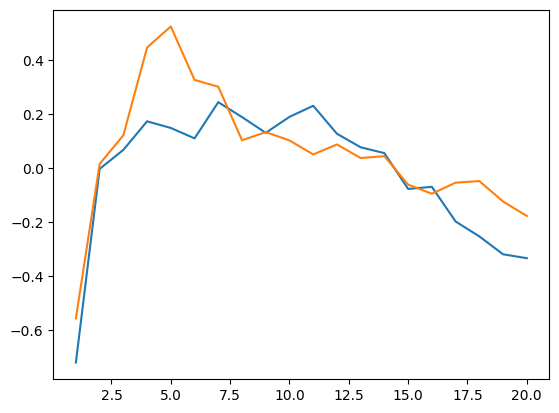

In [225]:
plt.plot(abscisse,r_perf_dtw)
plt.plot(abscisse,c_perf_dtw)

In [220]:
neigh = KNeighborsRegressor(n_neighbors=2,metric=dtw)
print('resampled',cross_val_score(neigh, resampled_X, y, cv=5))
neigh = KNeighborsRegressor(n_neighbors=2,metric=dtw)
print('cut',cross_val_score(neigh, ndvi_cut, y, cv=5))


resampled [-2.97545541 -2.24548221 -0.05149311 -0.72130007  0.10425033]
cut [-2.1242664  -0.53005488  0.13574517 -2.08332357  0.23862294]
